# MNIST image classification with Convolutional Neural Network

In [1]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow as tf
import datetime
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

2023-10-22 16:06:16.043682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the Data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Pre-processing
Our MNIST images only have a depth of 1, but we must explicitly declare that

In [4]:
num_classes = 10
epochs = 15

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /=255.0
X_test /=255.0
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


## Create & Compile the Model



![Diagram](./model-arch.png)

In [6]:
cnn = Sequential()

In [7]:
cnn.add(
    Conv2D(
        32,
        kernel_size=(5, 5),
        input_shape=(28, 28, 1),
        padding='same',
        activation='relu'
    )
)

In [8]:
cnn.add(MaxPooling2D())

In [9]:
cnn.add(
    Conv2D(
        64,
        kernel_size=(5, 5),
        padding='same',
        activation='relu'
    )
)

In [10]:
cnn.add(MaxPooling2D())

In [11]:
cnn.add(Flatten())

In [12]:
cnn.add(
    Dense(1024, activation='relu')
)

In [13]:
cnn.add(
    Dense(10, activation='softmax')
)

In [14]:
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1024)              3

## Train the Model

### Create callbacks for tensorboard and early stopping

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=3
)

In [17]:
def create_tensorboard_callback():
  logdir = os.path.join('./logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

In [18]:
tensorboard = create_tensorboard_callback()

### Fit the model

In [19]:
cnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    verbose=1,
    validation_data=(X_train, y_train),
    callbacks=[tensorboard, early_stopping]
)

Epoch 1/15
1875/1875 [==============================] - 115s 61ms/step - loss: 0.0958 - accuracy: 0.9703 - val_loss: 0.0432 - val_accuracy: 0.9862
Epoch 2/15
1875/1875 [==============================] - 119s 64ms/step - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0195 - val_accuracy: 0.9940
Epoch 3/15
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.0326 - val_accuracy: 0.9891
Epoch 4/15
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0064 - val_accuracy: 0.9982
Epoch 5/15
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0056 - val_accuracy: 0.9983
Epoch 6/15
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0041 - val_accuracy: 0.9987
Epoch 7/15
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0

In [20]:
score = cnn.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0659 - accuracy: 0.9888


## Create a function to save our model

In [21]:
def save_model(model, suffix=None):
  """
  saves a given model in our models directry and appends a suffix string
  """
  # create a model directory with current time
  modeldir = os.path.join(
      "./models",
      datetime.datetime.now().strftime('%Y%m%m%d-%H%M%s')
  )

  model_path = modeldir + '-' + '.h5' # save format for models
  print(f"saving model to {model_path}...")
  model.save(model_path)

  return model_path

In [22]:
save_model(cnn)

saving model to ./models/2023101022-16361698007014-.h5...


/Users/gregmckenzie/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'./models/2023101022-16361698007014-.h5'

## Create function load model

In [23]:
def load_model(model_path):
  """
  loads a saved model from a specified path
  """
  print(f"loading saved model from {model_path}...")

  # load in our model!
  model = tf.keras.models.load_model(model_path)

  return model

In [28]:
cnn = load_model('./models/2023101022-16361698007014-.h5')

loading saved model from ./models/2023101022-16361698007014-.h5...


### Make Predictions

In [29]:
predictions = cnn.predict(X_test)

313/313 [==============================] - 2s 7ms/step


### Create a Confusion Matrix

In [30]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)

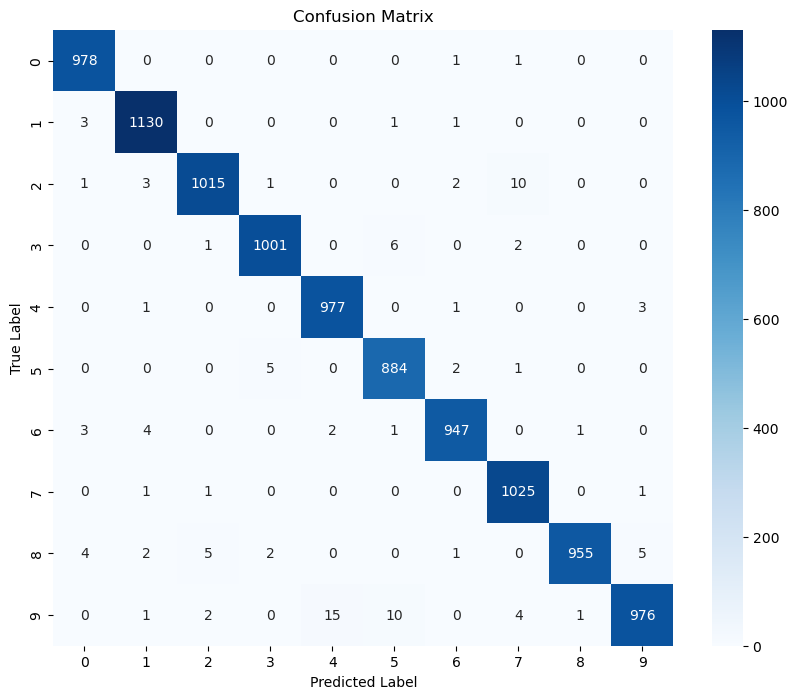

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()